# Siamese Network



In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
from tqdm import tqdm_notebook, tqdm, trange
import numpy as np
import pandas as pd
import itertools
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Lambda, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from DataPrep import preprocess_image, augment_pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## EDA

Explore the distribution of features that we will use to calculate similarity with Siamese Network


In [2]:
df = pd.read_csv('datasets/train.csv')
df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


### Select only top 8 whales

In [3]:
top_counts = df['Id'].value_counts()[:9]
top_counts.drop(index='new_whale', inplace=True)
top_counts

w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_ab4cae2    22
w_fd1cb9d    22
w_693c9ee    22
w_987a36f    21
Name: Id, dtype: int64

In [4]:
top_df = df[df['Id'].isin(top_counts.index)]
top_df

,Image,Id
1,000466c4.jpg,w_1287fbc
13,00467ae9.jpg,w_fd1cb9d
183,0496e682.jpg,w_fd1cb9d
253,0603a403.jpg,w_1287fbc
257,0617f982.jpg,w_7554f44
...,...,...
9379,f4063698.jpg,w_7554f44
9446,f5ac7c84.jpg,w_1287fbc
9464,f61f4cb3.jpg,w_ab4cae2
9518,f767cdfa.jpg,w_1eafe46


### Feature Extraction

We use ImageNet-DenseNet121 as feature extractor.
DenseNet121 produces 1024 dims feature. We can't use huge number of dimension data to visualize as scatter plot.
Then we reduce number of dimension to 2 with PCA.

In [8]:
def create_feature_extractor():
    backbone = DenseNet121(include_top=False,
                           weights='imagenet',
                           input_shape=(478, 968, 3)
                          )
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ])
    return model
feature_extractor = create_feature_extractor()

In [9]:
df = top_df.copy()
input_dir = Path('datasets/train/train')
imgs = [cv2.imread(str(input_dir / img_name)) for img_name in df['Image']]
imgs = [preprocess_image(img) for img in imgs]
imgs = np.array(imgs)

In [10]:
features = feature_extractor.predict(imgs, verbose=1)

7/7 [==============================] - 2s 254ms/step


In [11]:
pca = PCA(n_components=2)
pca.fit(features)
print('Eigenvalue', pca.explained_variance_)

Eigenvalue [0.373128 0.12637 ]


In [12]:
df['feature'] = list(pca.transform(features))
df

,Image,Id,feature
1,000466c4.jpg,w_1287fbc,"[-0.36179468, 0.71095705]"
13,00467ae9.jpg,w_fd1cb9d,"[-0.24768831, -0.2546858]"
183,0496e682.jpg,w_fd1cb9d,"[0.6061446, -0.13540277]"
253,0603a403.jpg,w_1287fbc,"[-0.28174284, -0.15205137]"
257,0617f982.jpg,w_7554f44,"[-0.5401064, 0.14370833]"
...,...,...,...
9379,f4063698.jpg,w_7554f44,"[-0.63355225, 0.50396895]"
9446,f5ac7c84.jpg,w_1287fbc,"[1.0977976, 0.37512797]"
9464,f61f4cb3.jpg,w_ab4cae2,"[-0.7986804, -0.2399579]"
9518,f767cdfa.jpg,w_1eafe46,"[-0.30703402, -0.41015247]"


In [13]:
features = np.concatenate(df['feature'].to_numpy()).reshape((-1, 2))

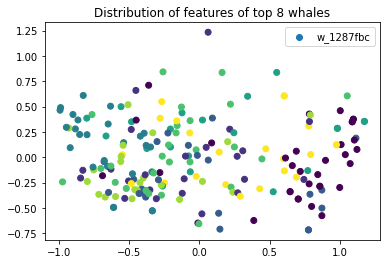

In [15]:
id_encoder = LabelEncoder()
_label = id_encoder.fit_transform(df['Id'])
# del label

plt.scatter(features[:, 0], features[:, 1], c=_label)
plt.legend(id_encoder.classes_.tolist())
plt.title('Distribution of features of top 8 whales')
plt.show()

The distribution of features that extracted from ImageNet-DenseNet121 look like very spread, have no cluster.
We hope Siamese Network will help CNN to produce greater cluster.

## Data Preprocessing

We generate pair images and boolean of similarity of this pair images ( "1" is same, "0" is not).

But our dataset contains a lot of whale ID. Some ID has small amount of image. If we create pair image for trainning by random method, It will lead to unbalance and the most of boolean of similarity will be "0". Our model will bias to predict "0" (not similar).

To prevent this problem, We implement data generator that can adjust ratio of "1" class (we call "positive class"). Default, set positive ratio at 0.5

In [3]:

class DataGenerator:
    
    def __init__(self, df, input_dir):
        self.input_dir = input_dir
        self.total_ids = set(df['Id'].drop_duplicates())
        self.df = df.set_index('Id')
    
    def create_generator(self, batch_size, positive_ratio=0.5, augment=False):
        while True:
            batch_df = self.df.sample(batch_size)

            lefts = []
            rights = []
            ys = []
            for Id1, whale1 in batch_df.iterrows():
                if np.random.rand() < positive_ratio:
                    candidate_df = self.df.loc[Id1]
                    y = 1
                else:
                    candidate_df = self.df.loc[self.total_ids - {Id1}]
                    y = 0

                if len(candidate_df) > 1:
                    whale2 = candidate_df.sample(1).iloc[0]
                else:
                    whale2 = candidate_df

                img1 = cv2.imread(str(self.input_dir / whale1['Image']))
                img2 = cv2.imread(str(self.input_dir / whale2['Image']))
                
                if augment:
                    img1, img2 = augment_pipeline.augment(images=[img1, img2])
                    
                img1 = preprocess_image(img1)
                img2 = preprocess_image(img2)

                lefts.append(img1)
                rights.append(img2)
                ys.append(y)

            lefts = np.array(lefts)
            rights = np.array(rights)
            ys = np.array(ys)
            
            yield [lefts, rights], ys

## Build Siamese Network

My time is running out T_T
I can only train this model with freeze CNN.

In [16]:
input_shape = (478, 968, 3)


feature_extractor = create_feature_extractor()
feature_extractor.trainable = False

left_input = Input(input_shape)
right_input = Input(input_shape)
left_features = feature_extractor(left_input)
right_features = feature_extractor(right_input)

distance_layer = Lambda(lambda f: K.abs(f[0] - f[1]))
distance = distance_layer([left_features, right_features])

similarity = Dense(1, activation='sigmoid')(distance)

model = Model(inputs=[left_input, right_input], outputs=similarity)

In [17]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 478, 968, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 478, 968, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         7037504     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024)         0           sequential_1[1][0]         

In [20]:
batch_size = 16
df = pd.read_csv('datasets/train.csv')
input_dir = Path('datasets/train/train')
datagen = DataGenerator(df, input_dir)
gen = datagen.create_generator(batch_size=batch_size, positive_ratio=0.5)

model_dir = Path('benchmark/siamese-densenet')
model_dir.mkdir(exist_ok=True)
model.fit(gen,
          initial_epoch=9,
          epochs=50,
          steps_per_epoch=len(df) // (2*batch_size),
          callbacks=[
              TensorBoard(str(model_dir)),
              ModelCheckpoint(str(model_dir / 'freeze-ep-{epoch:02d}-acc{acc:.4f}.hdf5'),
                        monitor='acc',
                        verbose=1,
                        save_best_only=True,
                        mode='max')
          ]
)


Epoch 10/50
307/307 [==============================] - ETA: 0s - loss: 0.4934 - acc: 0.7773
Epoch 00010: acc improved from -inf to 0.77728, saving model to benchmark/siamese-densenet/freeze-ep-10-acc0.7773.hdf5
307/307 [==============================] - 154s 502ms/step - loss: 0.4934 - acc: 0.7773
Epoch 11/50
307/307 [==============================] - ETA: 0s - loss: 0.4839 - acc: 0.7775
Epoch 00011: acc improved from 0.77728 to 0.77748, saving model to benchmark/siamese-densenet/freeze-ep-11-acc0.7775.hdf5
307/307 [==============================] - 154s 501ms/step - loss: 0.4839 - acc: 0.7775
Epoch 12/50
307/307 [==============================] - ETA: 0s - loss: 0.4683 - acc: 0.7875
Epoch 00012: acc improved from 0.77748 to 0.78746, saving model to benchmark/siamese-densenet/freeze-ep-12-acc0.7875.hdf5
307/307 [==============================] - 154s 501ms/step - loss: 0.4683 - acc: 0.7875
Epoch 13/50
307/307 [==============================] - ETA: 0s - loss: 0.4687 - acc: 0.7944
Epoch

KeyboardInterrupt: 

## Further development

- Evaluation
- Train model with unfreeze CNN
- Visualize distribution of feature